In [1]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet

import plotly.graph_objects as go
import plotly.express as px

In [ ]:
from sklearn.metrics import (accuracy_score, confusion_matrix,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error)

## Lectura de los datos

In [4]:
df = pd.read_parquet("dataForecast.parquet")
pd.set_option('display.max_columns', None)

## Seleccionamos los datos

In [44]:
airports = list(df['ORIGIN_AIRPORT'].unique())
airports

['LAX', 'DEN', 'PHX', 'ORD', 'IAH']

In [45]:
airport_1 = df[df['ORIGIN_AIRPORT'] == airports[0]]

In [19]:
# Distribución de los datos
airport_1_df = pd.DataFrame(airport_1.groupby(airport_1['DATE'])["FLIGHT_NUMBER"].count())
airport_1_df = airport_1_df.rename(columns={"FLIGHT_NUMBER":"TOTAL_FLIGHTS"})
airport_1_df["DELAYED_FLIGHTS"] =  airport_1[airport_1["ARRIVAL_DELAY"]>0].groupby(airport_1['DATE'])["FLIGHT_NUMBER"].count()
airport_1_df["DELAY_PERCENTAGE"] = np.round(airport_1_df['DELAYED_FLIGHTS']/airport_1_df['TOTAL_FLIGHTS']*100,2)

# Ordenamos los aeropuertos de tal manera que los 5 con mayor % de retrasos aparezcan los primeros
airport_1_df = airport_1_df.sort_values('DELAY_PERCENTAGE',ascending=False)
airport_1_df.describe()

,TOTAL_FLIGHTS,DELAYED_FLIGHTS,DELAY_PERCENTAGE
count,365.000000,365.000000,365.000000
mean,574.331507,234.493151,40.490795
std,45.841008,74.273500,11.575265
min,369.000000,62.000000,14.340000
25%,555.000000,184.000000,32.510000
50%,582.000000,227.000000,39.510000
75%,603.000000,283.000000,47.520000
max,645.000000,467.000000,76.560000


### Data preparation

In [20]:
data = airport_1_df.reset_index(level=0, drop=False)
data = data.loc[:,['DATE', 'DELAYED_FLIGHTS']] 
data['DATE'] = pd.to_datetime(data['DATE'])

# Cambiamos el nombre a las columnas para que vaya a corde con el modelo
data.columns = ['ds','y']
data['ds'] = pd.to_datetime(data['ds'],format = "%m/%d/%Y")
data = data.sort_values('ds')
data = data.reset_index(level=0, drop=True)
data.head()

,ds,y
0,2015-01-01,236
1,2015-01-02,409
2,2015-01-03,437
3,2015-01-04,467
4,2015-01-05,400


# Forecast

Variable a predecir: *number of delays per airport and day*

## Arima

## Neural Prophet

### Tunning

#### Seasonality Study

In [23]:
## Definimos la paleta usada con plotly express, para poder utilizarla con plotly normal
color_palette = px.colors.qualitative.Vivid

In [22]:
# Representación de los datos
fig = px.line(data, x="ds", y="y", labels={'ds':'Date', 'y':'Number of delays'},
              title = "Delayed flights per day",color_discrete_sequence=px.colors.qualitative.Vivid, template="plotly_dark")

#fig.update_traces({"line":{"color":"steelblue", 'dash':'dash'}})

fig.show()

Weekly seasonality?

In [38]:
aux = pd.DataFrame()
aux["DELAYED_FLIGHTS"] = data.groupby(data['ds'].dt.day_name())["y"].sum()
#data["Vuelos Retrasados"] = data[data["ARRIVAL_DELAY"]>0].groupby(data['DATE'].dt.day_name())["FLIGHT_NUMBER"].count()
aux = aux.reindex(index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
aux = aux.reset_index(level=0, drop=False)
aux

,ds,DELAYED_FLIGHTS
0,Monday,13185
1,Tuesday,11113
2,Wednesday,11848
3,Thursday,13600
4,Friday,13227
5,Saturday,9533
6,Sunday,13084


In [39]:
# Representación de los datos
fig = px.line(aux, x="ds", y="DELAYED_FLIGHTS", labels={'ds':'Date', 'DELAYED_FLIGHTS':'Number of delays'},
              title = "Delayed flights per Week day",color_discrete_sequence=px.colors.qualitative.Vivid, template="plotly_dark")

#fig.update_traces({"line":{"color":"steelblue", 'dash':'dash'}})

fig.show()

#### Modelling

Model variables explained in: https://neuralprophet.com/code/forecaster.html

In [ ]:
model = NeuralProphet(   
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=30,       # n_forecasts (int) – Number of steps ahead of prediction time step to forecast.
    n_lags= len(data)-30, # n_lags (int) – Previous time series steps to include in auto-regression
    num_hidden_layers=0,
    d_hidden=None,     # Dimension of hidden layers of AR-Net
    #ar_sparsity=None,  # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
    #log_level=None, # Determines the logging level of the logger object
)

In [ ]:
m.highlight_nth_step_ahead_of_each_forecast(step_number=m.n_forecasts)

In [18]:
# Data partition
train = data [:-30]
test = data [-30:] 

In [ ]:
en un modelo de forecast hay que hacer fit al modelo?

In [8]:
# Indicamos que nuestro periodo de predicción son días --> freq = 'D'
model = NeuralProphet()
metrics = model.fit(train, freq="D") 

# Dividir train y test

# Vamos a predecir el mes de diciembre
future = model.make_future_dataframe(data, periods=30) 
forecast = model.predict(future)
forecast.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 278


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 2.61E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 2.72E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[278/278]: 100%|█| 278/278 [00:47<00:00,  5.85it/s, SmoothL1Loss=0.018, MAE=44.2, RMSE=56.8, Loss=0.014, RegLoss=0
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 1040746 historic forecasts, reduced to 365.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.747% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.747% of the data.
INFO - (NP.df_utils._infer_freque

,ds,y,residual1,yhat1,trend,season_weekly
390,2016-01-26,None,NaN,221.824768,237.828812,-16.004055
391,2016-01-27,None,NaN,234.845856,238.332733,-3.486874
392,2016-01-28,None,NaN,259.127655,238.836670,20.290983
393,2016-01-29,None,NaN,254.405670,239.340576,15.065111
394,2016-01-30,None,NaN,188.440094,239.844498,-51.404400


In [9]:
forecast[-30*2:-30]

,ds,y,residual1,yhat1,trend,season_weekly
335,2015-12-02,166,40.62648,206.626480,210.113342,-3.486874
336,2015-12-03,208,22.908249,230.908249,210.617264,20.290983
337,2015-12-04,149,77.186295,226.186295,211.121185,15.065111
338,2015-12-05,82,78.220703,160.220703,211.625107,-51.404400
339,2015-12-06,190,39.951645,229.951645,212.129028,17.822611
340,2015-12-07,227,3.349564,230.349564,212.632935,17.716627
341,2015-12-08,219,-21.867203,197.132797,213.136856,-16.004055
342,2015-12-09,205,5.153885,210.153885,213.640762,-3.486874
343,2015-12-10,217,17.435684,234.435684,214.144699,20.290983
344,2015-12-11,201,28.71373,229.713730,214.648621,15.065111


In [10]:
forecast = model.predict(data)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (py.warnings._showwarnmsg) - C:\Users\gfine\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


WARNING - (py.warnings._showwarnmsg) - C:\Users\gfine\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.




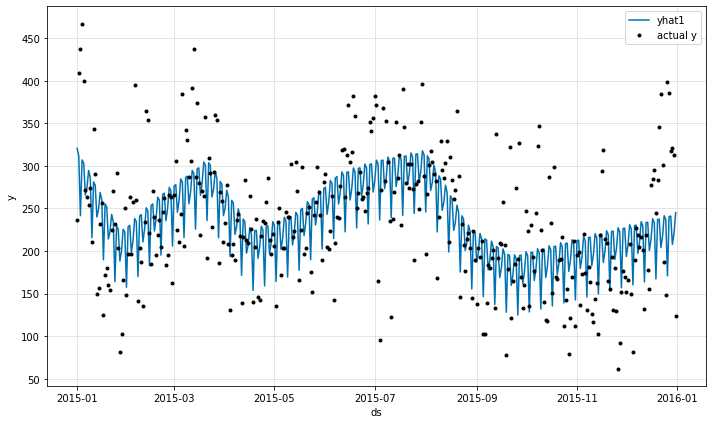

In [11]:
plot1 = model.plot(forecast)

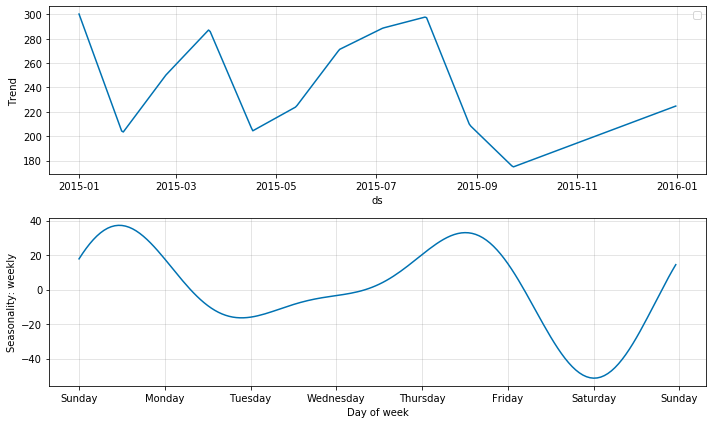

In [12]:
plt2 = model.plot_components(forecast)

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

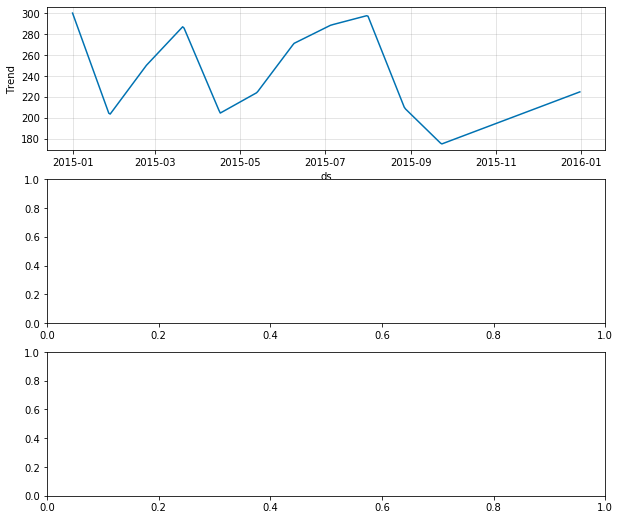

In [13]:
model.plot_parameters()

#### Training the model

In [14]:
int(1/12*365)

30

In [19]:
m = NeuralProphet()
df_train, df_val = m.split_df(data, freq='D', valid_p = 30)
metrics = m.fit(df_train, freq='D', validation_df=df_val)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.701% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (N

  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E+00, min: 1.83E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.86E-01, min: 1.27E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.55E-01
  0%|                                                                                          | 0/288 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - C:\Users\gfine\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:928: UserWarning:

Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch[288/288]: 100%|█| 288/288 [00:17<00:00, 16.85it/s, SmoothL1Loss=0.0144, MAE=39.1, RMSE=50.1, Loss=0.0108, RegLoss


In [22]:
# Make predictions using the fitted model once it has been fitted.
future = m.make_future_dataframe(data, periods=30, n_historic_predictions=len(data)-30)
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [ ]:
# Data preparation
# ==============================================================================
airport_1['DATE'] = pd.to_datetime(airport_1['DATE'], format='%Y/%m/%d')

# airport_1
airport_1 = airport_1.set_index('DATE')
airport_1 = airport_1.rename(columns={'ARRIVAL_DELAY': 'y'})
airport_1 = airport_1.asfreq('MS')
airport_1 = airport_1.sort_index()
airport_1.head()

In [ ]:
# 20% de los datos para test
steps = int(round(0.2*len(airport_1),0))

data_train = airport_1[:-steps]
data_test  = airport_1[-steps:]

print(f"Train dates : {data_train.DATE.min()} --- {data_train.DATE.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.DATE.min()} --- {data_test.DATE.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

#### Exploring the results

In [30]:
airport_1.head()

,DATE,IATA_CODE,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OTHER_DELAY,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,2015-01-01,AA,American Airlines Inc.,2336,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,West Palm Beach,FL,USA,26.68316,-80.09559
2,2015-01-01,AA,American Airlines Inc.,258,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Miami,FL,USA,25.79325,-80.29056
5,2015-01-01,US,US Airways Inc.,2013,LAX,CLT,30,44.0,14.0,13.0,57.0,273.0,249.0,228.0,2125,745.0,8.0,803,753.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Charlotte,NC,USA,35.21401,-80.94313
10,2015-01-01,DL,Delta Air Lines Inc.,1434,LAX,MSP,35,35.0,0.0,18.0,53.0,214.0,210.0,188.0,1535,601.0,4.0,609,605.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Minneapolis,MN,USA,44.88055,-93.21692
14,2015-01-01,AA,American Airlines Inc.,115,LAX,MIA,105,103.0,-2.0,14.0,117.0,286.0,276.0,255.0,2342,832.0,7.0,851,839.0,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Miami,FL,USA,25.79325,-80.29056


In [ ]:
a1["DEPARTURE_DELAY"] =  pd.DataFrame(df.groupby(df['ORIGIN_AIRPORT'])["FLIGHT_NUMBER"].count())

In [39]:
a1 = airport_1.loc[:,['DEPARTURE_DELAY','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY','OTHER_DELAY']]

In [40]:
a1['DEPARTURE_DELAY'].mean()

10.173232966498276

In [44]:
causas = pd.DataFrame(df.groupby(df['ORIGIN_AIRPORT'])["FLIGHT_NUMBER"].count())
causas = causas.rename(columns={"FLIGHT_NUMBER":"TOTAL_FLIGHTS"})
causas["DEPARTURE_DELAY"] =  df.groupby(df['ORIGIN_AIRPORT'])["DEPARTURE_DELAY"].mean()
causas['AIR_SYSTEM_DELAY'] = df.groupby(df['ORIGIN_AIRPORT'])["AIR_SYSTEM_DELAY"].mean()
causas['SECURITY_DELAY'] = df.groupby(df['ORIGIN_AIRPORT'])["SECURITY_DELAY"].mean()
causas['AIRLINE_DELAY'] = df.groupby(df['ORIGIN_AIRPORT'])["AIRLINE_DELAY"].mean()
causas['LATE_AIRCRAFT_DELAY'] = df.groupby(df['ORIGIN_AIRPORT'])["LATE_AIRCRAFT_DELAY"].mean()
causas['WEATHER_DELAY'] = df.groupby(df['ORIGIN_AIRPORT'])["WEATHER_DELAY"].mean()
causas['OTHER_DELAY'] = df.groupby(df['ORIGIN_AIRPORT'])["OTHER_DELAY"].mean()
causas = causas.reset_index(level=0, drop=False)
causas = causas.drop(['TOTAL_FLIGHTS'],axis = 1)
causas.head()

,ORIGIN_AIRPORT,DEPARTURE_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OTHER_DELAY
0,DEN,11.253477,2.665286,0.004360,3.773297,5.080930,0.446635,1.218764
1,IAH,11.146305,2.988715,0.016161,4.183317,4.351696,0.565534,1.274470
2,LAX,10.173233,2.241610,0.016639,3.588663,4.982808,0.162934,1.302307
3,ORD,13.194443,3.282250,0.009154,4.358625,5.251042,1.395416,1.102121
4,PHX,8.302053,1.916742,0.039151,3.439730,3.527740,0.219306,1.329553


In [59]:
# Contar el número de rergistros != por aeropuerto

In [58]:
# Causas
categories = ['DEPARTURE_DELAY','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',',LATE_AIRCRAFT_DELAY','WEATHER_DELAY','OTHER_DELAY']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=list(causas.iloc[0,1:]),
      theta=categories,
      fill='toself',
      name=str(causas.iloc[0,0])
))
fig.add_trace(go.Scatterpolar(
      r=list(causas.iloc[1,1:]),
      theta=categories,
      fill='toself',
      name=str(causas.iloc[1,0])
))

fig.add_trace(go.Scatterpolar(
      r=list(causas.iloc[2,1:]),
      theta=categories,
      fill='toself',
      name=str(causas.iloc[2,0])
))
              
fig.add_trace(go.Scatterpolar(
      r=list(causas.iloc[3,1:]),
      theta=categories,
      fill='toself',
      name= str(causas.iloc[3,0])
))

fig.add_trace(go.Scatterpolar(
      r=list(causas.iloc[4,1:]),
      theta=categories,
      fill='toself',
      name=str(causas.iloc[4,0])
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    )),
  showlegend=False
)

fig.show()

In [66]:
df = pd.read_csv("flightsCleaned.csv")
pd.set_option('display.max_columns', None)

In [78]:
# Creamos la columna tipo de vuelos
condition_distance = [
    (df['DISTANCE'] < 750) ,
    (df['DISTANCE'] >= 750) & (df['DISTANCE'] <1500),
    (df['DISTANCE'] >= 1500)]

choice_distance = ['Short', 'Mid', 'Long']

# Creamos la columna tipo de retraso
condition_delay = [
    (df['ARRIVAL_DELAY'] < 0) ,
    (df['ARRIVAL_DELAY'] <= 30) ,
    (df['ARRIVAL_DELAY'] > 30) & (df['DISTANCE'] <=60),
    (df['ARRIVAL_DELAY'] > 60)]

choice_delay = ['Early arrival', '(0-30)mins', '(30-60)mins','>1h']

In [ ]:
df['TYPE'] = np.select(condition_distance, choice_distance, default='Not Specified')
df['DELAY_TYPE'] = np.select(condition_delay, choice_delay, default='Not Specified')

In [ ]:
# Creamos la columna tipo de retraso
condition_multa = [
    (df['TYPE'] == 'Early arrival') | (df['TYPE'] == '(0-30)mins'),
    (df['DISTANCE'] == 'Short') & (df['ARRIVAL_DELAY'] == '(30-60)mins'),
    (df['DISTANCE'] == 'Mid') & (df['ARRIVAL_DELAY'] == '(30-60)mins'),
    (df['DISTANCE'] == 'Long') & (df['ARRIVAL_DELAY'] == '(30-60)mins'),   
    
    (df['DISTANCE'] == 'Short') & (df['ARRIVAL_DELAY'] == '>1h'),
    (df['DISTANCE'] == 'Mid') & (df['ARRIVAL_DELAY'] == '>1h'),
    (df['DISTANCE'] == 'Long') & (df['ARRIVAL_DELAY'] == '>1h')]

choice_multa = [0,5000,10000,20000,7500,20000,40000]

In [ ]:
df['FINE'] = np.select(condition_multa, choice_multa, default='Not Specified')

In [ ]:
#df = df.loc[:, ['ORIGIN_AIRPORT','DISTANCE', 'TYPE']]

In [ ]:
df['TYPE'] = np.select(conditionlist, choicelist, default='Not Specified')
df = df.loc[:, ['ORIGIN_AIRPORT','DISTANCE', 'TYPE']]

distnaces = pd.DataFrame(df.groupby(df['ORIGIN_AIRPORT'])["FLIGHT_NUMBER"].count())
distnaces = distnaces.rename(columns={"FLIGHT_NUMBER":"TOTAL_FLIGHTS"})
distnaces["DELAYED_FLIGHTS"] =  df[df["ARRIVAL_DELAY"]>0].groupby(df['ORIGIN_AIRPORT'])["FLIGHT_NUMBER"].count()
distnaces["DELAY_PERCENTAGE"] = np.round(airports['DELAYED_FLIGHTS']/airports['TOTAL_FLIGHTS']*100,2)
